In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
#import spacy
import string
import collections
!pip install pymorphy2
import pymorphy2
from pymorphy2 import MorphAnalyzer
from nltk import sent_tokenize, word_tokenize, regexp_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ab57f9a3b665d49025077b472d6ef602ef5736bd9ef02a7761e04a99394b6e7a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
df = pd.read_csv("/content/BRFRD.csv", encoding='UTF8', sep=",")
df = df[:5000]
df.head()

,review,rating,published,full review url
0,"«Головоломка» — продукт универсальный, и, чтоб...",90,2015-6-22,http://www.kino-mir.ru/posts/view/147
1,"А если подвести итоги, то Пиксар создал, не по...",100,2015-6-18,https://www.uralweb.ru/poster/reviews/6694.html
2,И все же плюсы «Головоломки» перевешивают ее м...,100,2015-6-19,http://www.tramvision.ru/recensia/2015/golovol...
3,"На выходе из зала есть ощущение, что Pixar сде...",100,2015-6-18,http://afisha.ngs.ru/news/more/2181412/
4,"Да, перед нами настоящий, старой школы пиксаро...",100,2015-6-16,http://www.kinokadr.ru/articles/2015/06/17/ins...


In [ ]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('russian'))
# функция, удаляющая стопслова из текстов
def stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
# Удаление эмодзи
def emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
#Удаление URL
# Function for url's
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)
from bs4 import BeautifulSoup
#Function for removing html
def html(text):
    return BeautifulSoup(text, "lxml").text



def tokenize_lemmas(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    return [morph.parse(tok)[0].normal_form
            for tok in regexp_tokenize(sent, pat)]

In [ ]:
df['text_ready']  = df['review'].str.lower()
df['text_ready'] = df['text_ready'].str.replace('\d+', '')
df['text_ready'] = df['text_ready'].str.replace('[^\w\s]','')
df["text_ready"] = df["text_ready"].apply(stopwords)
df['text_ready'] = df['text_ready'].apply(emoji)
df['text_ready'] = df['text_ready'].apply(remove_urls)
df['text_ready'] = df['text_ready'].apply(html)
df["text_ready"] = df["text_ready"].map(lambda x: " ".join(tokenize_lemmas(x)))
df[['text_ready']].head()

<ipython-input-4-09e7b31d74d4>:25: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "lxml").text


,text_ready
0,головоломка продукт универсальный проникнуться...
1,подвести итог пиксара создать побояться этот с...
2,плюс головоломка перевешивать минус там лента ...
3,выход зал ощущение pixar сделать свой хороший ...
4,да мы настоящий старый школа пиксаровский шеде...


In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [ ]:
w2v_model = Word2Vec(
    min_count=5,
    window=5,
    vector_size=1000,
    negative=5,
    workers=24,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

In [ ]:
#Получаем лист слов
from gensim.utils import simple_preprocess

class MySentences(object):
    def __init__(self, docs):
        self.corpus = docs
    def __iter__(self):
        for doc in self.corpus:
            doc_sentences = sent_tokenize(doc)
            for sent in doc_sentences:
                yield simple_preprocess(sent)

In [ ]:
sentences = MySentences(df['text_ready'].tolist())

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
w2v_model.build_vocab(sentences)

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

(212571, 509055)

In [ ]:
w2v_model.init_sims(replace=True)

<ipython-input-13-c7757d71a30b>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [ ]:
w2v_model.wv.most_similar(positive=["плохой"], topn=10)

[('тьма', 0.9997801184654236),
 ('граница', 0.9997787475585938),
 ('начинаться', 0.9997780323028564),
 ('оба', 0.9997773170471191),
 ('слишком', 0.9997770190238953),
 ('материал', 0.9997766613960266),
 ('минута', 0.999776303768158),
 ('летний', 0.9997753500938416),
 ('верить', 0.9997745156288147),
 ('космос', 0.9997738003730774)]

In [ ]:
w2v_model.wv.most_similar(positive=["жанр", "режиссёр", "сюжет"], topn=10)

[('кстати', 0.9998669028282166),
 ('роберт', 0.999863862991333),
 ('гэг', 0.9998634457588196),
 ('показ', 0.999862790107727),
 ('любовник', 0.999862790107727),
 ('абсурд', 0.999862551689148),
 ('вместе', 0.9998599290847778),
 ('превращаться', 0.9998594522476196),
 ('ситуация', 0.9998594522476196),
 ('обаяние', 0.9998581409454346)]

In [ ]:
w2v_model.wv.most_similar(positive=["жанр", "режиссёр", "сюжет"], negative=["плохой"], topn=10)

[('роберт', 0.9997974634170532),
 ('превращаться', 0.9997928142547607),
 ('кстати', 0.9997926950454712),
 ('гэг', 0.9997920989990234),
 ('показ', 0.9997907876968384),
 ('близкий', 0.9997905492782593),
 ('абсурд', 0.9997893571853638),
 ('вечный', 0.9997884631156921),
 ('мастер', 0.999788224697113),
 ('душевный', 0.9997872710227966)]

In [ ]:
w2v_model.wv.most_similar_to_given("плохой", ["жанр", "режиссёр", "сюжет", "музыка"])

'музыка'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np

def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    vectors_words = [model.wv.word_vec(word)]
    word_labels = [word]
    color_list = ['red']

    close_words = model.wv.most_similar(word)
    for wrd_score in close_words:
        wrd_vector = model.wv.word_vec(wrd_score[0])
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')

    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.word_vec(wrd)
        vectors_words.append(wrd_vector)
        word_labels.append(wrd)
        color_list.append('green')


    # t-SNE reduction
    Y = (TSNE(n_components=2, random_state=0, perplexity=10, init="pca").fit_transform(np.array(vectors_words)))
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                       "y": [y for y in Y[:, 1]],
                       "words": word_labels,
                       "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)

    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

<ipython-input-52-d19c003280fe>:10: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  vectors_words = [model.wv.word_vec(word)]
<ipython-input-52-d19c003280fe>:16: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd_score[0])
<ipython-input-52-d19c003280fe>:23: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  wrd_vector = model.wv.word_vec(wrd)


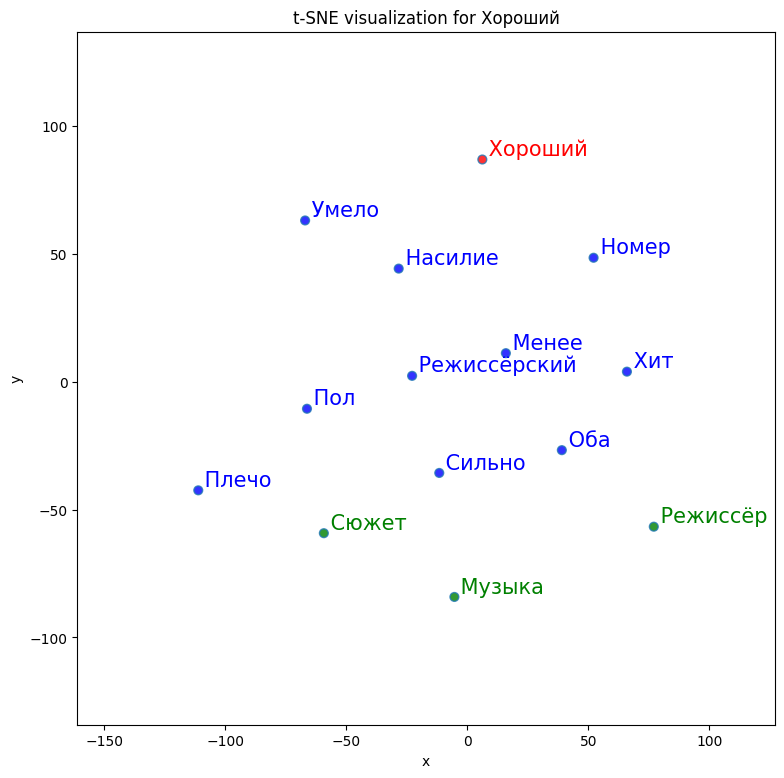

In [ ]:
tsne_scatterplot(w2v_model, "хороший" , ["музыка", "режиссёр" , "сюжет"])

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True)

In [ ]:
texts = df.text_ready
texts

,text_ready
0,головоломка продукт универсальный проникнуться...
1,подвести итог пиксара создать побояться этот с...
2,плюс головоломка перевешивать минус там лента ...
3,выход зал ощущение pixar сделать свой хороший ...
4,да мы настоящий старый школа пиксаровский шеде...
...,...
4995,новый блистательный драма главное современный ...
4996,изумительно красивый фильм снятой волшебный ка...
4997,нелюбовь весь свой мрачность пожалуй самый поз...
4998,психологически тяжёлый фильм шокировать свой и...


In [ ]:
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(texts)

In [ ]:
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]


In [ ]:
df1 = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names_out(), columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False)[:10]

,tfidf
нарастить,0.307310
сухарь,0.307310
чёрствый,0.293189
придираться,0.283170
изрядный,0.283170
головоломка,0.269050
цинизм,0.254929
любящий,0.254929
слой,0.254929
проникнуться,0.247941
